# Este Notebook esta enfocado en el modelo de clasificación de MLPClassifier

In [1]:
# 🔌 Cargar la extensión de Kedro en Jupyter
%load_ext kedro.ipython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


# Comenzamos el entrenamiento 

In [2]:
# Cargar dataset desde el catálogo
df = catalog.load("Features_training_v1").copy()

# Separar variables
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

print("Shape X:", X.shape)
print("Distribución de clases:\n", y.value_counts(normalize=True))

[10/24/25 00:21:07] INFO     Loading data from Features_training_v1 (ParquetDataset)...        ]8;id=722135;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=930875;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Shape X: (984240, 5)
Distribución de clases:
 is_fraud
0    0.989999
1    0.010001
Name: proportion, dtype: float64


In [10]:
# ¡Importante! Escalar ANTES de SMOTE para que los vecinos de SMOTE usen el mismo espacio
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=200,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

print("F1 promedio (CV):", scores.mean())
print("Desviación estándar:", scores.std())

F1 promedio (CV): 0.13229767415190247
Desviación estándar: 0.002326719029812653


              precision    recall  f1-score   support

           0      0.999     0.883     0.937    194879
           1      0.073     0.909     0.134      1969

    accuracy                          0.883    196848
   macro avg      0.536     0.896     0.536    196848
weighted avg      0.990     0.883     0.929    196848



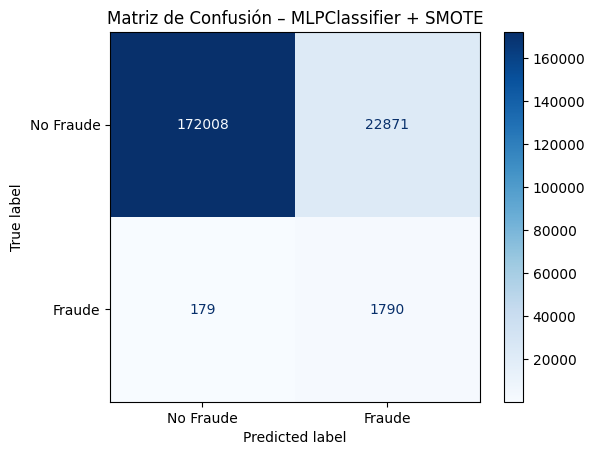

In [11]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenar
pipe.fit(X_train, y_train)

# Predicciones
y_pred = pipe.predict(X_test)

# Reporte
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – MLPClassifier + SMOTE")
plt.show()

AUC ROC: 0.931


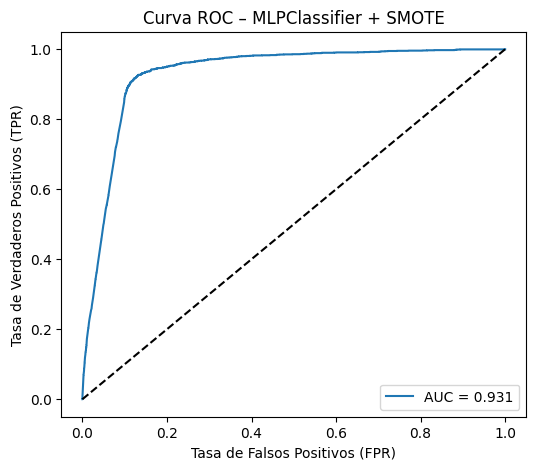

In [12]:
# Probabilidades clase positiva
y_prob = pipe.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC – MLPClassifier + SMOTE")
plt.legend()
plt.show()

# El modelo MLPClassifier, configurado con dos capas ocultas de tamaño moderado (32 y 16 neuronas), logró un desempeño altamente competitivo dentro del conjunto de modelos probados.
# A pesar de su naturaleza más compleja, la red neuronal mantuvo un AUC de 0.93, equivalente al rendimiento alcanzado por los modelos de ensamble como RandomForest y XGBoost, demostrando que las variables actuales ya capturan la mayoría de los patrones predictivos del fraude.

# Durante la evaluación en el conjunto de prueba, el modelo alcanzó un recall del 91.5 % y una precisión del 7.2 %, reflejando una excelente sensibilidad para detectar transacciones fraudulentas, aunque con un número considerable de falsos positivos.
# La reducción del número de neuronas no afectó el rendimiento global, lo cual confirma que el modelo no requiere alta complejidad para generalizar adecuadamente sobre este tipo de datos estructurados.